# Randomized Field Arrays
Another notebook in the series of analysis of Mark's trap array design. Here I analyze aperiodic arrays and arrays with randomized phase from aperture to aperture.

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift
from scipy.special import j0, j1
import matplotlib.pyplot as plt
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

## Randomized Input Masks
Now use an input field created with random noise-- either in phase or periodicity

In [215]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

b=0.005031, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000101


In [ ]:
def spot_mask(xnum, ynum, a, dx, dy, pts, pos_std=None, phi_std=None, plate=0, aperture=1):
    """
    Warning: this will may not work as expected if xnum or ynum is odd
    Args:
        xnum: # of spots in x (columns)
        ynum " " " " y (rows)
        a: aperture spot radius
        dx: center-center distance in x
        dy: " " " " y
        pts: number of pts in one dimesnsion in the 2D array output. ie output
            mask is pts x pts
        pos_std: std for randomness added to spot centers. should be a decimal 
            representing percentage of 'a', e.g. 0.10 would give normally
            distributed noise with sigma = 0.10*a
        phi_std: std for random phase given to each aperture unit cell. units are in 2*pi and phase is sampled from
            from a normal dist. phi_std = 0.1 would correspond to sigma 0.1*2*pi radians, so there is a 
            +/- 10% spread of phase over the apertures compared to the plate. Note that to create mask where 
            this phase is only applied to the spot, plate must be set to 0. after creating the mask with this function,
            you can then add a constant to offset the transmittance of the whole mask
        plate: 0 by default; plate transmittance
        aperture: 1 by default; aperture transmittance
    Returns: 
        2D array, xarr: binary mask of spots, and 1D array of real space x coordinates.
            The realspace full width of the grid 2*w = (max(xnum,ynum) + 1)*dx
    """

    w = (max(xnum,ynum) + 1)*dx/2 # array real space half-width 
    res = 2*w/pts # real space distance between adjacent pts

    # make subgrid and build a single aperture mask:
    subpts = int(2*a/res) # number of pts to make a side length 2*a
    assert subpts % 2 == 0, "try a slightly different even number of points so that sub-array width is even"
    
    sarr,smidpt,srr,sphi = get_meshgrid(a, subpts, polar=True)
    smask = zeros((subpts,subpts))
    qd3 = smask[:smidpt,:smidpt]
    
    # TODO: build binary phase mask component matrices as on the whiteboard
    if phi_std is not None:
        phase = lambda :random.normal(0, 2*pi*phi_std) 
    else:
        phase = lambda :0
    
    for j in range(smidpt):
        for i in range(smidpt):
            qd3[i,j] = int(srr[i,j] < a)
        
    
    smask = from_quadrant3(qd3, smask)

    # the centroids of the apertures
    xpts, ypts = get_grid(dx,dy,xnum,ynum)
    
    # add noise, optionally
    if pos_std is not None:
        # TODO: add noise from a normal dist of sigma = std*a 
        xpts = array([x + nx for x,nx in zip(xpts,random.normal(0,pos_std,xnum*ynum))])
        ypts = array([y + ny for y,ny in zip(ypts,random.normal(0,pos_std,xnum*ynum))])
    
    # convert centroids to mask indices
    yidcs = [int((y + w)/res) for y in ypts]
    xidcs = [int((x + w)/res) for x in xpts]

    midpt = int(pts/2)
    mask = full((pts, pts), plate, complex)

    # build the mask
    for i in yidcs:
        for j in xidcs:
            mask[i-smidpt:i+smidpt,j-smidpt:j+smidpt] = smask*exp(1j*phase())
            
    # real space coordinates
    xarr = [i*res - w for i in range(pts)]
            
    return mask, xarr

In [217]:
pts = 1000
mask, x1pts = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=0.1)

(42, 42)


MemoryError: 

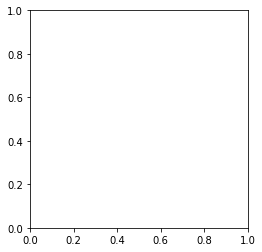

In [220]:
plt.close()
fig,ax = figax()
cbar=ax.contourf(mask)
fig.colorbar(cbar)

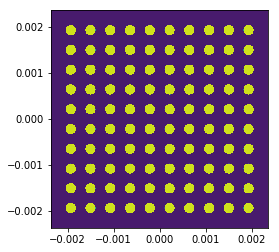

In [177]:
# xpts, ypts = get_grid(dx,dy,xnum,ynum)
# ax.scatter(xpts,ypts)
fig, ax = figax()
ax.contourf(x1pts, x1pts, mask)

## program to solve output field for a range of specified parameter values

In [2]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = 0.7*dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

## grid params

w = 4*b # grid half-width
pts = 2000 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

## misc
padding = 100 # pad the field with 100 rows/cols of zeros to increase fft res

b=0.005031, a=0.0001, dx=0.00043, dy=0.000301, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000049


In [50]:
## compute the output field for various values of dy using this packaged prodedure

# save contour plots as pngs?
showcontour=False # must be true in order to save file
savefile=False

# scaled real space pts for output array
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6

lines = []
labels = []

for alpha in arange(.7,1.3,.05):

    dy = alpha*dx

    field1 = # TODO: get field from a 2D fft of a randomized input grid

    ## calculate the output intensity, normalized to intensity in focal plane
    # always run with z2 = f2 first
    for z in [0, zTalbotx]:
        z2 = f2 - z
        field2,_ = get_outputfield(z2,field1,b,f2,k,x1pts,rr,padding)

        I2_xy = conjugate(field2)*field2
        if f2 - z2 == 0:
            I2xy_max = amax(I2_xy) 
#             print(f"set the I2xy_max={I2xy_max}")
        I2_xy = 1 - I2_xy/I2xy_max 
    
        fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_dydx{int(100*dy/dx)}_{xnum}x{ynum}.png'

        if showcontour:
            fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]')
            fig.dpi = 200
            cbar = ax.contourf(x2pts*scl, x2pts*scl, I2_xy)
            fig.colorbar(cbar)
            ax.set_title(rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m] | {xnum}x{ynum} | dy/dx={dy/dx:0.2f}')
            if savefile:
                plt.savefig(fname, bbox_inches='tight')
                print('wrote file to',fname)
                plt.close()

    lines.append(I2_xy[:,midpt+11])
    labels.append(f'dy/dx={dy/dx:0.2f}')

calculated field1 in 13.833039045333862 s
f2 - z2 = 0.0
calculated field2 in 0.7210707664489746 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7958729267120361 s
calculated field1 in 12.732946634292603 s
f2 - z2 = 0.0
calculated field2 in 0.7061119079589844 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7829060554504395 s
calculated field1 in 12.46167254447937 s
f2 - z2 = 0.0
calculated field2 in 0.6881611347198486 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7868936061859131 s
calculated field1 in 13.167784452438354 s
f2 - z2 = 0.0
calculated field2 in 0.7220687866210938 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7978682518005371 s
calculated field1 in 12.585339069366455 s
f2 - z2 = 0.0
calculated field2 in 0.7858946323394775 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.8078393936157227 s
calculated field1 in 12.66912031173706 s
f2 - z2 = 0.0
calculated field2 in 0.7071089744567871 s
f2 - z2 = 0.0001008545454545453
calculated f

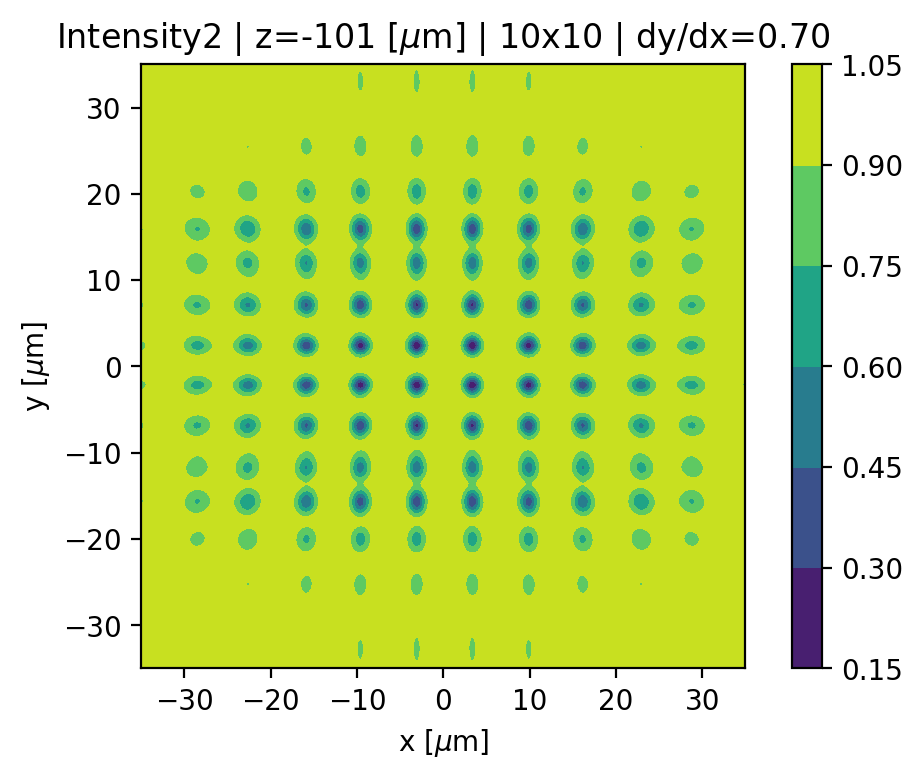

In [14]:
Image('dark_I2xy_z101um_dydx70_10x10.png')

wrote file to i2_slice_x-3.21um_z100.85um_dydx100_125.png


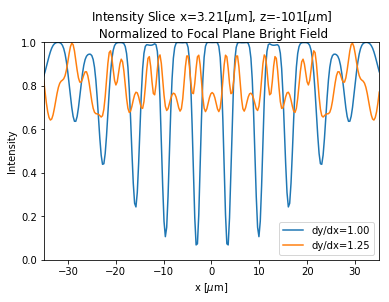

In [76]:
## plot the lines calculated above -- intensity slices in y

savefile = True
fname = f'i2_slice_x{x2pts[midpt-12]*scl:0.2f}um_z{(f2-z2)*scl:0.2f}um_dydx100_125.png'

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6

fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'Intensity',aspect=None)
ax.set_title(rf'Intensity Slice x={x2pts[midpt+11]*scl:0.2f}[$\mu$m], z={(z2-f2)*scl:0.0f}[$\mu$m]'+'\n Normalized to Focal Plane Bright Field')
ax.set_ylim(0,1)
# stop_idx = 7
# for line,label in zip(lines[:stop_idx],labels[:stop_idx]): 
#     ax.plot(x2pts*scl, line, label=label)
for i in [6,11]:
    ax.plot(x2pts*scl, lines[i], label=labels[i])
ax.legend(loc='lower right')

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)